### Coding Guide

Unfortunately, you can't learn R or any coding language in 2 hours. However, this guide and the attached code contains everything you need to go from a free download of publicly available NHL data to your own linear model, which you can customize as you see fit. I included the annoying data cleaning steps so you can see what basically 90% of any analytical job or project entails, but I do think it's more important to make sure you focus on understanding what's going on with the modeling aspect. Also, if you show any part of this code to someone and they're like "There's a better, easier way to do this!", that's cool. Do that, then.

By the way, the keyboard shortcut to run one line of code in a file is Ctrl+Enter for Windows and Command+Enter for Mac. You can follow along by running these commands in RStudio.

In RStudio, there are 4 windows. The top left is for you to write and save your code, the bottom left is for you to see the output, the top right keeps track of variables and intermediate things that you have saved, and the bottom right is a viewer for plots/packages/etc. Let's do a basic thing first.

In [1]:
x <- 3

2*x

[1] 6

Cool, we just assigned the number 3 to the variable x, and now we can use that in formulas and stuff. There's definitely a lot to learn about data structures and things, and you can click [here](http://stat.wharton.upenn.edu/~buja/STAT-961/Chapter01-Intro-OverviewR-StatInference.R) to get exposed to some of that. We are moving *very quickly* onward.

Now, for the data cleaning + modeling. First, I got the data from [Corsica](https://www.corsica.hockey). If you're interested in supporting Manny for the wonderful work he does for all of us, click [here](https://www.patreon.com/corsica). I went to the skater stats tab, included the last four full seasons, disaggregated the stats (so player seasons show up individually), set the time on ice minimum at 0, and downloaded stats for all situations, even strength, power play, and penalty kill. These files are sitting in my downloads folder, and they may also be sitting in yours. <b>IMPORTANT: You have to change the file path to make sure you're reading in the data from the right folder, or use the file.choose() option as outlined in the instructional video.</b>

In [2]:
pp_orig <- read.csv("~/Downloads/pp.csv", check.names=FALSE)
es_orig <- read.csv("~/Downloads/es.csv", check.names=FALSE)
pk_orig <- read.csv("~/Downloads/pk.csv", check.names=FALSE)
all_orig <- read.csv("~/Downloads/all.csv", check.names=FALSE)

R reads in the csv files and assigns them to the variables we've specified. These variables are now dataframes, which is the most common data structure for model building. The check.names=FALSE command tells R not to get rid of any strange characters in the column names, as we'll do so manually later on. I appended "_orig" to each dataframe name to distinguish them from the cleaned up versions we'll use later on.

In [3]:
#install.packages('ggplot2')
#install.packages('dplyr')

In [4]:
library(ggplot2)
library(dplyr)

Warning message:
“package ‘dplyr’ was built under R version 3.4.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



One of the first things you have to do in any R script is install and load any additional packages you need. You only have to install a package once, so for future projects, you can just load in these packages using the library() command. R can do a lot of good things on its own, but one of the best parts is that it's very easy to add any additional functionality as long as someone out there has created a package for it. ggplot2 and dplyr are some of the most popular packages. ggplot2 makes nice graphs, and dplyr makes it easier and more intuitive to modify your data/columns/etc. Also, I didn't suppress the warning message because I think those freak people out sometimes but you can often just ignore them!

Now, time for data cleaning. One of the habits I like to emphasize is doing all of my data cleaning in R. When you start with coding, there's a tendency to do some of the quicker cleaning steps in Excel, like removing and renaming columns. But we're going to do that in R, because 1) we won't lose any info from our original data files that we may like to come back to and 2) it's easier and quicker moving forward to apply these steps to other data files.

Since there are 4 different data frames and multiple cleaning steps we need to take, I'm eventually going to write a function that applies these same cleaning protocols to each dataframe. First, let's take a quick look at how functions work.

In [5]:
test_function <- function(a,b,c){
    d <- a^2+3*b+c^4
    d <- 0.5*d
    return(d)
}

test_function(3,2,1)
d

[1] 8

ERROR: Error in eval(expr, envir, enclos): object 'd' not found


I define all the variables I need to include in the function, in this case a, b, and c. The function does some arithmetic to those variables, assigns it to the variable d, and then returns d as the output. You'll notice that d is not permanently saved as a variable in the process.

Now, let's figure out the data cleaning steps we need to take. First, let's take a look at the data. head() is a really nice command for this. It shows you the first 6 rows in the data.

In [6]:
head(all_orig)

Player,Season,Team,Position,GP,TOI,G,A,P,P1,⋯,ixGF,ixGF/60,iSh%,PDO,ZSR,TOI%,TOI% QoT,CF% QoT,TOI% QoC,CF% QoC
AARON.EKBLAD,2014-2015,FLA,D,81,1766.60,12,27,39,22,⋯,9.11,0.31,7.06,100.62,66.19,35.68,30.40,53.99,30.17,46.05
AARON.EKBLAD,2015-2016,FLA,D,78,1690.83,15,20,35,23,⋯,9.81,0.35,8.24,101.92,60.39,35.80,31.18,52.08,30.95,47.13
AARON.EKBLAD,2016-2017,FLA,D,68,1459.28,10,11,21,14,⋯,12.03,0.49,4.44,97.21,64.51,35.12,30.87,54.64,30.87,47.02
AARON.NESS,2013-2014,NYI,D,20,295.88,1,1,2,1,⋯,1.27,0.26,4.35,91.63,50.86,24.39,27.13,48.67,29.44,50.97
AARON.NESS,2015-2016,WSH,D,8,99.10,0,2,2,0,⋯,0.39,0.24,0.00,108.83,69.23,20.83,24.26,50.15,27.63,48.05
AARON.NESS,2016-2017,WSH,D,2,25.67,0,0,0,0,⋯,0.02,0.05,NA,92.31,90.91,22.47,25.77,51.14,27.12,49.44


But since this dataframe has a lot of columns, we don't see all of them. We can also see the dimensions (rows * columns) and column names to get a better idea of what's going on. 

In [7]:
dim(all_orig)
colnames(all_orig)

[1] 3558   44

[1] "Player"   "Season"   "Team"     "Position" "GP"       "TOI"     
 [7] "G"        "A"        "P"        "P1"       "P/60"     "P1/60"   
[13] "GS"       "GS/60"    "CF"       "CA"       "C+/-"     "CF%"     
[19] "Rel CF%"  "GF"       "GA"       "G+/-"     "GF%"      "Rel GF%" 
[25] "xGF"      "xGA"      "xG+/-"    "xGF%"     "Rel xGF%" "iPENT"   
[31] "iPEND"    "iP+/-"    "iCF"      "iCF/60"   "ixGF"     "ixGF/60" 
[37] "iSh%"     "PDO"      "ZSR"      "TOI%"     "TOI% QoT" "CF% QoT" 
[43] "TOI% QoC" "CF% QoC"

We can also look at any subset of rows and columns. Let's say we just want to use the first 10 rows and 5 columns.

In [8]:
all_orig[1:10,1:5]

Player,Season,Team,Position,GP
AARON.EKBLAD,2014-2015,FLA,D,81
AARON.EKBLAD,2015-2016,FLA,D,78
AARON.EKBLAD,2016-2017,FLA,D,68
AARON.NESS,2013-2014,NYI,D,20
AARON.NESS,2015-2016,WSH,D,8
AARON.NESS,2016-2017,WSH,D,2
AARON.PALUSHAJ,2013-2014,CAR,R,2
AARON.ROME,2013-2014,DAL,D,25
AARON.VOLPATTI,2013-2014,WSH,L,41
AARON.VOLPATTI,2014-2015,WSH,L,2


Okay, so the first problem is that there seem to be some columns we don't necessarily need, so let's list them all out in a vector using the c function, which apparently stands for "combine." The more you know, etc.

In [9]:
remove <- c('C+/-','G+/-','xG+/-','iPENT','iPEND','iP+/-','ZSR','TOI% QoT','CF% QoT','TOI% QoC','CF% QoC')

Then, we can tell R to select all of those columns and make them NULL, which is my favorite way of removing them. There are other ways, but I don't care about those ways. I made a copy of the all_orig dataframe and named it x because I don't want to mess with it, just in case I have to come back to it later and don't want to rerun all this code.

In [10]:
x <- all_orig
x[,remove] <- list(NULL)

Now, there are some characters to get rid of. R doesn't particularly like "%" and "/" and " " in column names. We can replace "%" with "pct", "/" with ".", and " " with nothing at all. We use the gsub function for this, and reassign the column names.

In [11]:
colnames(x) <- gsub(" ", "", colnames(x))
colnames(x) <- gsub("%", "pct", colnames(x))
colnames(x) <- gsub("/", ".", colnames(x))

There's just one last step, I promise. Well, not really, there are many steps. Data cleaning is one long descent into hell, and that's exactly where I live. Hell. Anyway, soon we'll be merging all the situations together and we can't have duplicate column names. So since this is all situations, I want to preface all of the variables that change across data sets with "all_".

In [12]:
colnames(x)[5:ncol(x)] <- paste('all', colnames(x)[5:ncol(x)], sep = "_")

Okay, some moving parts here. First of all, I wanted to leave the first four columns unchanged because they stay constant across everything, so I'm applying this function to column 5 onward to the last column. The ncol function always tells us the number of columns there are in total, so it's also the number of the last column. What we're doing to these column names is pasting 'all_' before each one. Now, let's check in on these column names.

In [13]:
colnames(x)

[1] "Player"        "Season"        "Team"          "Position"     
 [5] "all_GP"        "all_TOI"       "all_G"         "all_A"        
 [9] "all_P"         "all_P1"        "all_P.60"      "all_P1.60"    
[13] "all_GS"        "all_GS.60"     "all_CF"        "all_CA"       
[17] "all_CFpct"     "all_RelCFpct"  "all_GF"        "all_GA"       
[21] "all_GFpct"     "all_RelGFpct"  "all_xGF"       "all_xGA"      
[25] "all_xGFpct"    "all_RelxGFpct" "all_iCF"       "all_iCF.60"   
[29] "all_ixGF"      "all_ixGF.60"   "all_iShpct"    "all_PDO"      
[33] "all_TOIpct"

Looks good, now let's do it 4 more times! This is where functions can help so we don't have to keep copying and pasting. If you had like 10 or 20 dataframes to fix up, you could write a loop or something, but we can live with calling this function 4 times.

In [14]:
clean_cols <- function(x,y){
    x[,remove] <- list(NULL)
    colnames(x) <- gsub(" ","",colnames(x))
    colnames(x) <- gsub("%","pct",colnames(x))
    colnames(x) <- gsub("/",".",colnames(x))
    colnames(x)[5:ncol(x)] <- paste(y, colnames(x)[5:ncol(x)], sep = "_")
    return(x)
}

pp <- clean_cols(pp_orig,'pp')
es <- clean_cols(es_orig,'es')
pk <- clean_cols(pk_orig,'pk')
all <- clean_cols(all_orig,'all')

The function clean_cols returns a fixed up dataframe x, and you also tell it y, which is what you'd like to preface the columns with. I assigned the cleaned up dataframes to new, shorter variables, which we will use for the merging process.

And now, we have to think about how we're going to bring all this data together. Again, it's not important that you retain anything from these next few merging and cleaning steps right away, but I'm including the code as a reference just in case you ever have to do something similar.

In [15]:
total <- merge(x = all, y = pp, by = c('Player','Season','Team','Position'), all.x = TRUE)
total <- merge(x = total, y = es, by = c('Player','Season','Team','Position'), all.x = TRUE)
total <- merge(x = total, y = pk, by = c('Player','Season','Team','Position'), all.x = TRUE)

What happened here? I kept merging the updated dataframes together and reassigning them the name "total". So for example, after the first line of code, the total dataframe contains the all situations and power play data. Then, we merge that dataframe with the even strength dataframe, and then we merge *that* one with the penalty kill dataframe. It's an iterative process. "all.x = TRUE" means these are all left joins, for those of you who are familiar with SQL. The "by =" argument tells R which columns to use to join all the rest of the columns together into one monstrous dataframe.

In [16]:
colnames(total)

[1] "Player"        "Season"        "Team"          "Position"     
  [5] "all_GP"        "all_TOI"       "all_G"         "all_A"        
  [9] "all_P"         "all_P1"        "all_P.60"      "all_P1.60"    
 [13] "all_GS"        "all_GS.60"     "all_CF"        "all_CA"       
 [17] "all_CFpct"     "all_RelCFpct"  "all_GF"        "all_GA"       
 [21] "all_GFpct"     "all_RelGFpct"  "all_xGF"       "all_xGA"      
 [25] "all_xGFpct"    "all_RelxGFpct" "all_iCF"       "all_iCF.60"   
 [29] "all_ixGF"      "all_ixGF.60"   "all_iShpct"    "all_PDO"      
 [33] "all_TOIpct"    "pp_GP"         "pp_TOI"        "pp_G"         
 [37] "pp_A"          "pp_P"          "pp_P1"         "pp_P.60"      
 [41] "pp_P1.60"      "pp_GS"         "pp_GS.60"      "pp_CF"        
 [45] "pp_CA"         "pp_CFpct"      "pp_RelCFpct"   "pp_GF"        
 [49] "pp_GA"         "pp_GFpct"      "pp_RelGFpct"   "pp_xGF"       
 [53] "pp_xGA"        "pp_xGFpct"     "pp_RelxGFpct"  "pp_iCF"       
 [57] "pp_iCF.60"     "pp_ixGF"       "pp_ixGF.60"    "pp_iShpct"    
 [61] "pp_PDO"        "pp_TOIpct"     "es_GP"         "es_TOI"       
 [65] "es_G"          "es_A"          "es_P"          "es_P1"        
 [69] "es_P.60"       "es_P1.60"      "es_GS"         "es_GS.60"     
 [73] "es_CF"         "es_CA"         "es_CFpct"      "es_RelCFpct"  
 [77] "es_GF"         "es_GA"         "es_GFpct"      "es_RelGFpct"  
 [81] "es_xGF"        "es_xGA"        "es_xGFpct"     "es_RelxGFpct" 
 [85] "es_iCF"        "es_iCF.60"     "es_ixGF"       "es_ixGF.60"   
 [89] "es_iShpct"     "es_PDO"        "es_TOIpct"     "pk_GP"        
 [93] "pk_TOI"        "pk_G"          "pk_A"          "pk_P"         
 [97] "pk_P1"         "pk_P.60"       "pk_P1.60"      "pk_GS"        
[101] "pk_GS.60"      "pk_CF"         "pk_CA"         "pk_CFpct"     
[105] "pk_RelCFpct"   "pk_GF"         "pk_GA"         "pk_GFpct"     
[109] "pk_RelGFpct"   "pk_xGF"        "pk_xGA"        "pk_xGFpct"    
[113] "pk_RelxGFpct"  "pk_iCF"        "pk_iCF.60"     "pk_ixGF"      
[117] "pk_ixGF.60"    "pk_iShpct"     "pk_PDO"        "pk_TOIpct"

This looks kinda overwhelming (and it's about to get even more so), but again, just remember that the naming convention is very standardized.

One way to get a quick overview of the distributions of every variable is to use the summary() command. This will also help you keep track of variables with a lot of NA entries. For the purposes of the models we're constructing here, that's not a huge concern, as those entries are automatically excluded when we run a regression model, but of course it's something to be aware of. The summary output is pretty long with all variables included, so I just looked at the first 16 for illustrative purposes.

In [17]:
summary(total[,1:16])

            Player           Season         Team         Position   
 ADAM.CRACKNELL:   4   2013-2014:889   CGY    : 124   D      :1216  
 ADAM.HENRIQUE :   4   2014-2015:881   BUF    : 119   C      :1114  
 ADAM.LARSSON  :   4   2015-2016:898   N.J    : 119   L      : 617  
 ADAM.MCQUAID  :   4   2016-2017:890   VAN    : 117   R      : 590  
 ADAM.PARDY    :   4                   PIT    : 116   C/L/L  :   3  
 ALEC.MARTINEZ :   4                   BOS    : 115   C/C/R  :   2  
 (Other)       :3534                   (Other):2848   (Other):  16  
     all_GP         all_TOI            all_G            all_A      
 Min.   : 1.00   Min.   :   0.78   Min.   : 0.000   Min.   : 0.00  
 1st Qu.:20.00   1st Qu.: 237.38   1st Qu.: 1.000   1st Qu.: 2.00  
 Median :60.00   Median : 855.53   Median : 4.000   Median : 8.00  
 Mean   :49.77   Mean   : 822.32   Mean   : 7.411   Mean   :12.28  
 3rd Qu.:77.00   3rd Qu.:1311.77   3rd Qu.:11.000   3rd Qu.:20.00  
 Max.   :91.00   Max.   :2411.97   Max. 

Next, we need to start lagging data. Lag columns have data from previous years, which is important because that's what we use to predict the current year.

Here, I employ the package dplyr, which has its own grammar. I would require an additional 2 hours to explain everything you can do with it, but suffice it to say that the commands are actually much more intuitive than base R. Here, we're telling it to group by Player, and then create new columns by applying the lag function to all variables between all_TOI and pk_TOIpct, and then lagging twice, and then three times. The pipe operator (%>%) simply tells R to move the modified values to the next line/function.

I made 400 ES minutes in a season as our cutoff for inclusion: you can use any cutoff you want by simply replacing the number 400 below with a number of your choice!.

In [18]:
lagged <- total %>%
    group_by(Player) %>%
    mutate_at(
        vars(all_TOI:pk_TOIpct),
        funs("lag1" = lag,"lag2" = lag(.,2),"lag3" = lag(.,3))) %>%
    filter(es_TOI >= 400 & pp_TOI >= 0 & pk_TOI >= 0) %>%
    ungroup

In [19]:
dim(lagged)
head(lagged)

[1] 2324  465

Player,Season,Team,Position,all_GP,all_TOI,all_G,all_A,all_P,all_P1,⋯,pk_xGA_lag3,pk_xGFpct_lag3,pk_RelxGFpct_lag3,pk_iCF_lag3,pk_iCF.60_lag3,pk_ixGF_lag3,pk_ixGF.60_lag3,pk_iShpct_lag3,pk_PDO_lag3,pk_TOIpct_lag3
AARON.EKBLAD,2014-2015,FLA,D,81,1766.60,12,27,39,22,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AARON.EKBLAD,2015-2016,FLA,D,78,1690.83,15,20,35,23,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AARON.EKBLAD,2016-2017,FLA,D,68,1459.28,10,11,21,14,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ADAM.CLENDENING,2016-2017,NYR,D,31,489.93,2,9,11,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ADAM.CRACKNELL,2015-2016,VAN/EDM,R,52,636.01,5,5,10,9,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ADAM.CRACKNELL,2016-2017,DAL,R,69,721.75,10,6,16,13,⋯,0.43,2.27,-4.44,0,0,0,0,NA,100,1.97


If you scroll back up, you'll see that the 400 even strength minutes minimum ended up excluding roughly 1000 player seasons. We also have over 400 columns now, which is scary. But remember the naming convention. Start with the variable itself, like CF. Preface it with the situation you're interested in, like "es_CF". If it's from 2 years ago, add "_lag2" to the end. "es_CF_lag2". Perfect.

Okay, let's quickly look at some of this data. With graphs. With ggplot, you specify the data you're using, the aesthetic mappings, and the type of graph. This basically refers to variables that you're including. For example, if I say fill = 'skyblue', that means the fill is sky blue. Beautiful. But if I say aes(fill=all_P), that means the fill color changes based on how many points the player scored. For a basic histogram, we just have one variable, which is points in all situations in this case.

You could run the code *hist(total$all_P)* to get a histogram in base R graphics. I do not even want to show you this output. Run it on your own computer if you wish.

By the way, using $ is a quick way to refer to just one column within a dataframe.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


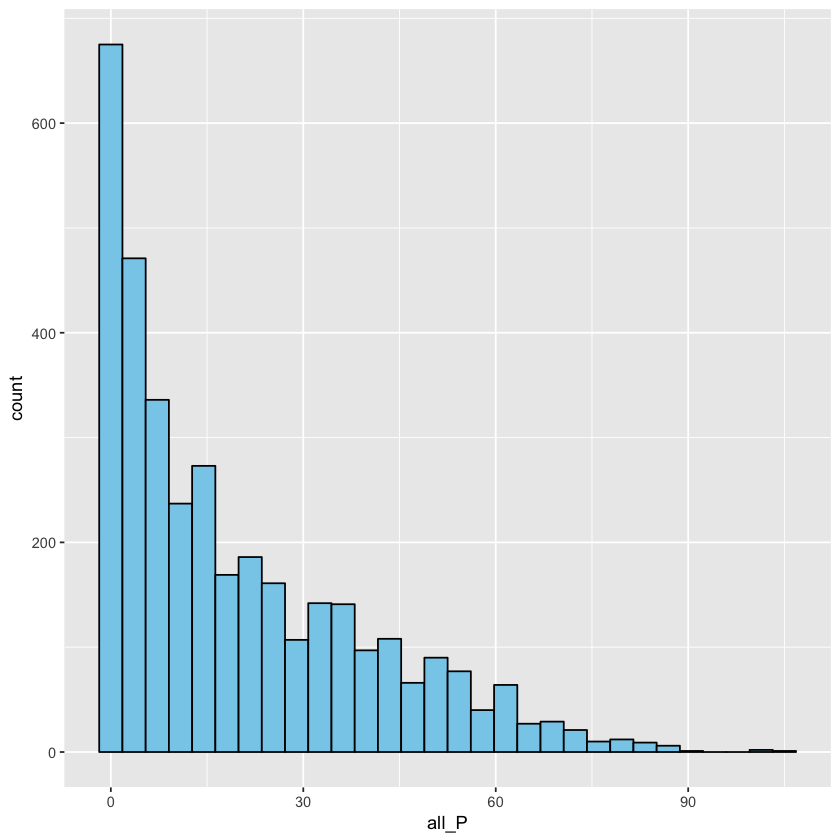

In [20]:
ggplot(data=total,aes(all_P)) + geom_histogram(fill="skyblue",col="black")

Beautiful. Now, let's make a scatterplot. Why don't we look at even strength and power play points? For this, we'll need x and y aesthetic mappings.

Warning message:
“Removed 55 rows containing missing values (geom_point).”

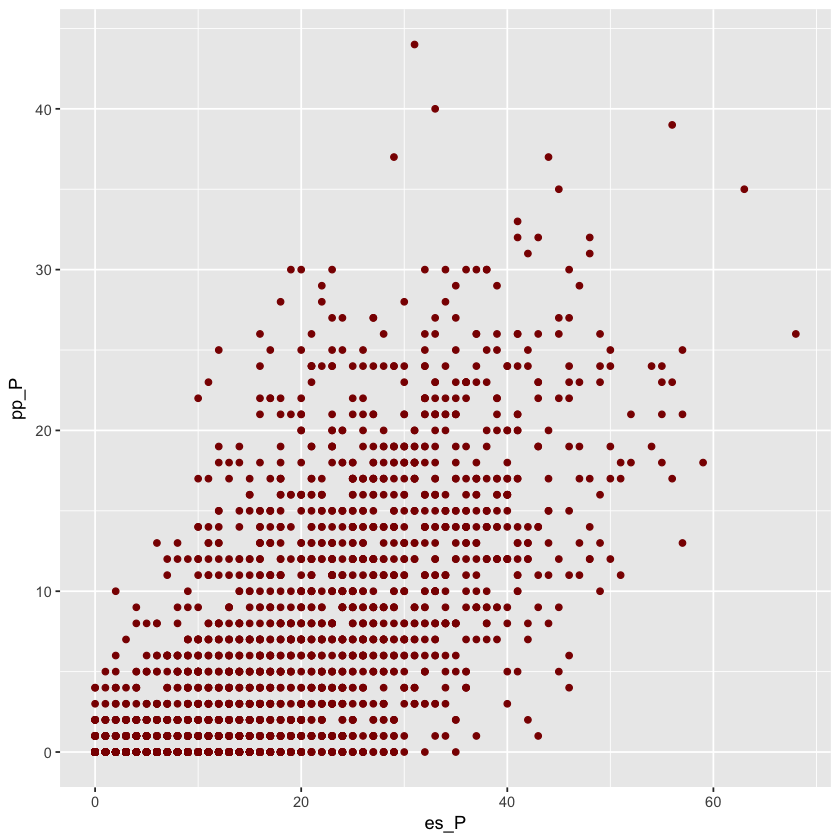

In [21]:
ggplot(data=total,aes(x=es_P,y=pp_P)) + geom_point(col="darkred")

Word. That's fun. There are a lot of other commands that ggplot can handle to make the plots [prettier](http://ggplot2.tidyverse.org/reference/).

Okay, time for regression. Let's use one predictor first. I like to make a smaller dataframe with just the columns that I'm using for the model, but you can also use the original and specify which columns you're using in the formula. This method is shown in the comment below.

In [22]:
model1_data <- lagged[,c('all_P','all_P_lag1')]

model1 <- lm(all_P ~ .,data=model1_data)
#model1 <- lm(all_P ~ all_P_lag1,data=lagged)
summary(model1)


Call:
lm(formula = all_P ~ ., data = model1_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.785  -8.114  -1.387   6.953  56.264 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  8.31961    0.51122   16.27   <2e-16 ***
all_P_lag1   0.73784    0.01489   49.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.9 on 1635 degrees of freedom
  (687 observations deleted due to missingness)
Multiple R-squared:  0.6002,	Adjusted R-squared:  0.5999 
F-statistic:  2454 on 1 and 1635 DF,  p-value: < 2.2e-16


We see that the previous year's points predicts reasonably well, with more than half of variation explained (r<sup>2</sup> = 0.6). Our estimate of this season's points is 8.31961 + 0.73784*(last season's points). You can probably already tell that this will be a conservative estimate of the some of the high-scoring players in the league, and an optimistic estimate for the Mark Borowieckis of the world.

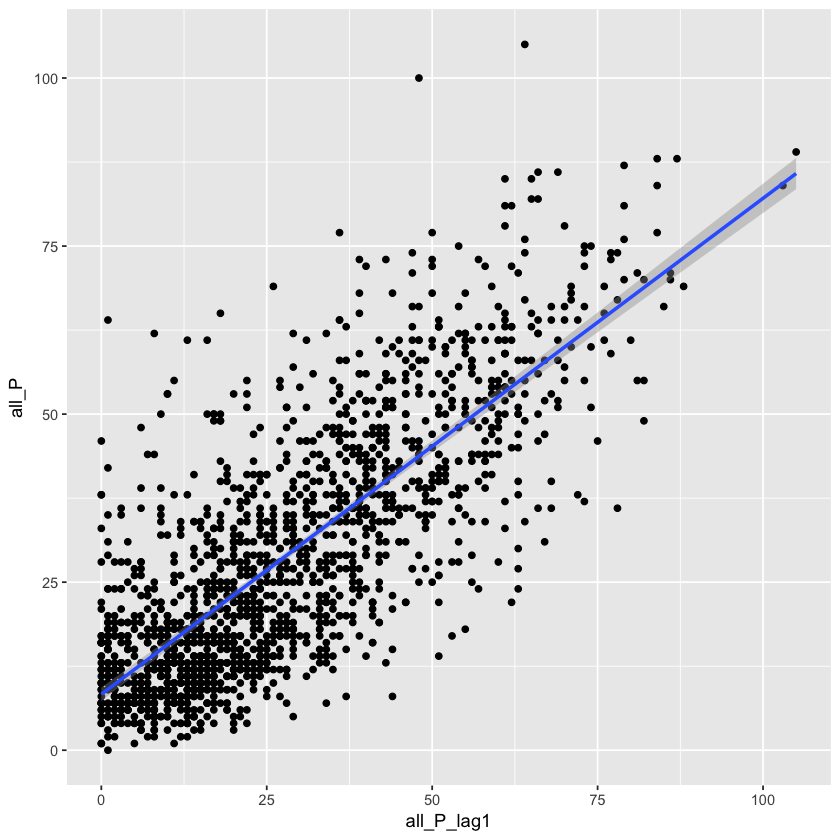

In [23]:
ggplot(data=model1,aes(x=all_P_lag1,y=all_P)) + geom_point() + geom_smooth(method='lm',formula=y~x)

We can see that we're pretty confident of the general trend, but it's tough to predict any individual point.

Adding a few more predictors here. In multiple regression, the slope estimate for a variable is the estimate of its effect holding all other variables constant. Also, let's move to points/60, as this might be easier to predict if players have varying numbers of games played across seasons.

In [24]:
lagged$Position <- factor(lagged$Position)
levels(lagged$Position)

[1] "C"     "C/C/R" "D"     "L"     "L/L/C" "L/L/R" "R"     "R/R/C"

In [25]:
levels(lagged$Position) <- c('C','C','D','L','L','L','R','R')
levels(lagged$Position)

[1] "C" "D" "L" "R"

I wanted to include position, which is categorical, so I checked on the possible values. For the players with multiple positions, I assigned them the first one listed. I also decided to include primary points/60 as a predictor, as many analysts have shown that primary points are more repeatable. I even threw in Dom Luszczyszyn's [Game Score](https://hockey-graphs.com/2016/07/13/measuring-single-game-productivity-an-introduction-to-game-score/) metric for fun.

In [26]:
model2_data <- lagged[,c('all_P.60','all_P.60_lag1','all_P1.60_lag1', 'all_P.60_lag2',
                          'Position', 'all_GS_lag1', 'all_GS_lag2')]

model2 <- lm(all_P.60 ~ ., data=model2_data)
#model2 <- lm(all_P.60 ~ all_P.60_lag1 + all_P1.60_lag1 + all_P.60_lag2 +
#             Position + all_GS_lag1 + all_GS_lag2',data=lagged)
summary(model2)


Call:
lm(formula = all_P.60 ~ ., data = model2_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.19930 -0.24256 -0.02551  0.22573  1.56977 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.469908   0.053191   8.834  < 2e-16 ***
all_P.60_lag1   0.279095   0.074179   3.762 0.000179 ***
all_P1.60_lag1  0.153117   0.083725   1.829 0.067741 .  
all_P.60_lag2   0.186955   0.032274   5.793 9.40e-09 ***
PositionD      -0.268571   0.044239  -6.071 1.83e-09 ***
PositionL      -0.046201   0.038719  -1.193 0.233083    
PositionR       0.020476   0.039049   0.524 0.600141    
all_GS_lag1     0.004510   0.001299   3.473 0.000538 ***
all_GS_lag2     0.001866   0.001044   1.786 0.074352 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.387 on 952 degrees of freedom
  (1363 observations deleted due to missingness)
Multiple R-squared:  0.7156,	Adjusted R-squared:  0.7132 
F-statistic: 299.4 on 8 a

We can see that these coefficients make intuitive sense. We would expect the coefficient for defensemen to be negative, for example, because they score less than centers, who are the default value for this model. The coefficients for wingers aren't significantly different than the default expectation for centers, though. All of the other coefficients are positive because if you scored and played well in the past, we expect that to continue. Plus, it seems that the most recent lagged predictors, the lag1 variables, are more important than the lag2 variables because their coefficients are larger in magnitude. We are also explaining more variation in this model than the first one, although they aren't directly comparable because we're looking at different response variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


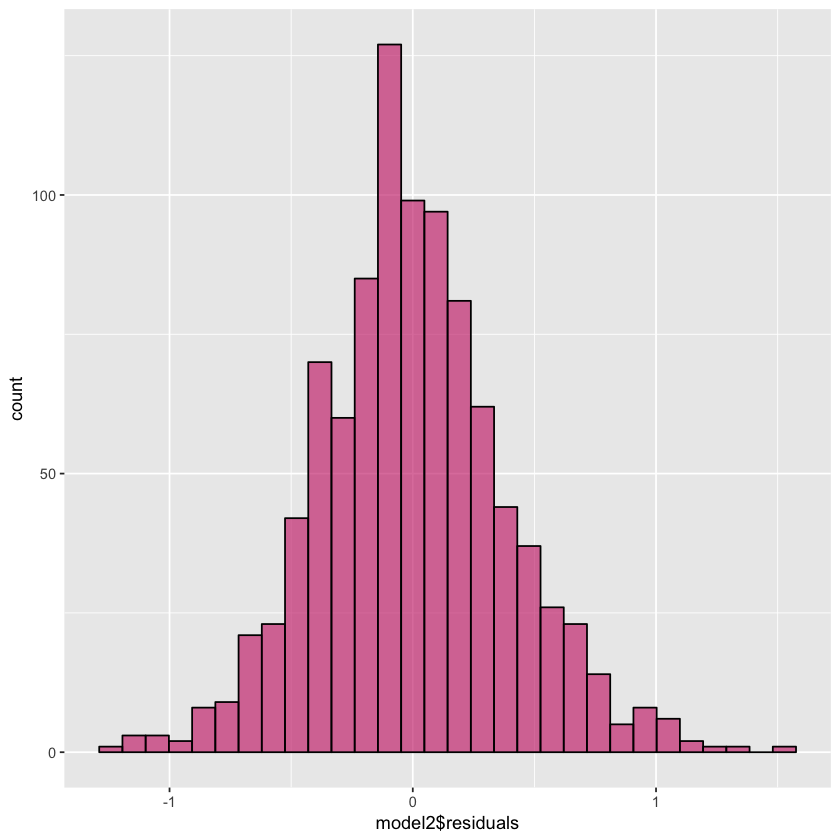

In [27]:
ggplot(data=model2,aes(model2$residuals)) + geom_histogram(fill="violetred3",col="black",alpha=0.65)

These are the model residuals, or the differences between the actual values and the predicted values from our model. We want them to all be 0, but it's encouraging that most of them are clustered around 0 and look pretty evenly distributed on either side.

In [28]:
model2_fulldata <- subset(lagged, all_P.60_lag2 >= 0)
model2_fulldata$Prediction <- predict(model2,newdata=model2_fulldata)
model2_fulldata$Residual <- model2$residuals
model2_fulldata <- model2_fulldata[,c('Player','Season','Team','Position','all_P.60','all_P.60_lag1',
                                      'Prediction','Residual')]
head(model2_fulldata[order(-model2_fulldata$Residual),])
head(model2_fulldata[order(model2_fulldata$Residual),])

Player,Season,Team,Position,all_P.60,all_P.60_lag1,Prediction,Residual
VIKTOR.ARVIDSSON,2016-2017,NSH,L,2.67,1.38,1.1002335,1.569767
EVGENY.KUZNETSOV,2015-2016,WSH,C,3.24,2.03,1.8705795,1.369421
SAM.GAGNER,2016-2017,CBJ,C,2.70,1.31,1.4864526,1.213547
LEON.DRAISAITL,2016-2017,EDM,C,2.98,2.31,1.8124951,1.167505
CURTIS.MCKENZIE,2016-2017,DAL,L,1.67,0.00,0.5709898,1.099010
ALEKSANDER.BARKOV,2015-2016,FLA,C,2.71,1.74,1.6574510,1.052549


Player,Season,Team,Position,all_P.60,all_P.60_lag1,Prediction,Residual
JOE.COLBORNE,2016-2017,COL,C,0.72,2.38,1.919296,-1.199296
CARL.SODERBERG,2016-2017,COL,C,0.78,2.07,1.925742,-1.145742
ANTON.LANDER,2015-2016,EDM,C,0.24,2.10,1.345196,-1.105196
VERNON.FIDDLER,2016-2017,N.J/NSH,L,0.35,1.38,1.452016,-1.102016
JIMMY.HAYES,2016-2017,BOS,R,0.56,1.68,1.646502,-1.086502
BENOIT.POULIOT,2016-2017,EDM,L,0.89,2.38,1.969351,-1.079351


Looking at residuals attached to specific players, we see that Arvidsson was the biggest positive surprise, and Joe Colborne was the biggest negative surprise last year.

Plotting the distribution of all situations points/60 below.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


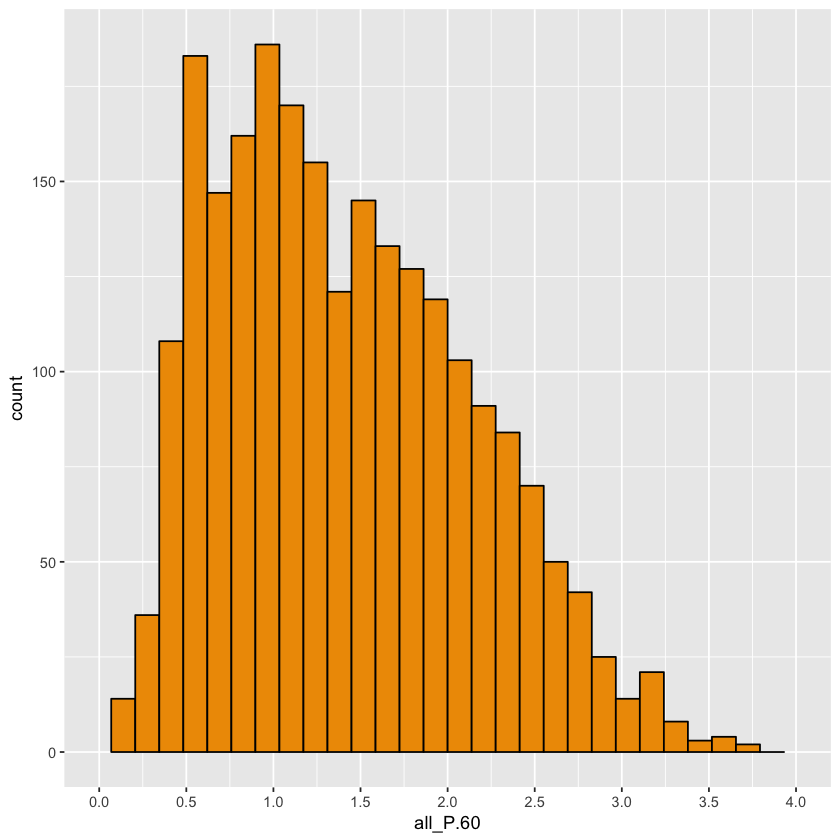

In [29]:
ggplot(data=lagged,aes(all_P.60)) + geom_histogram(fill="orange2",col="black") +
scale_x_continuous(limits = c(0,4),breaks=seq(0,4,.5))

Now let's look at the distribution of our predictions.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


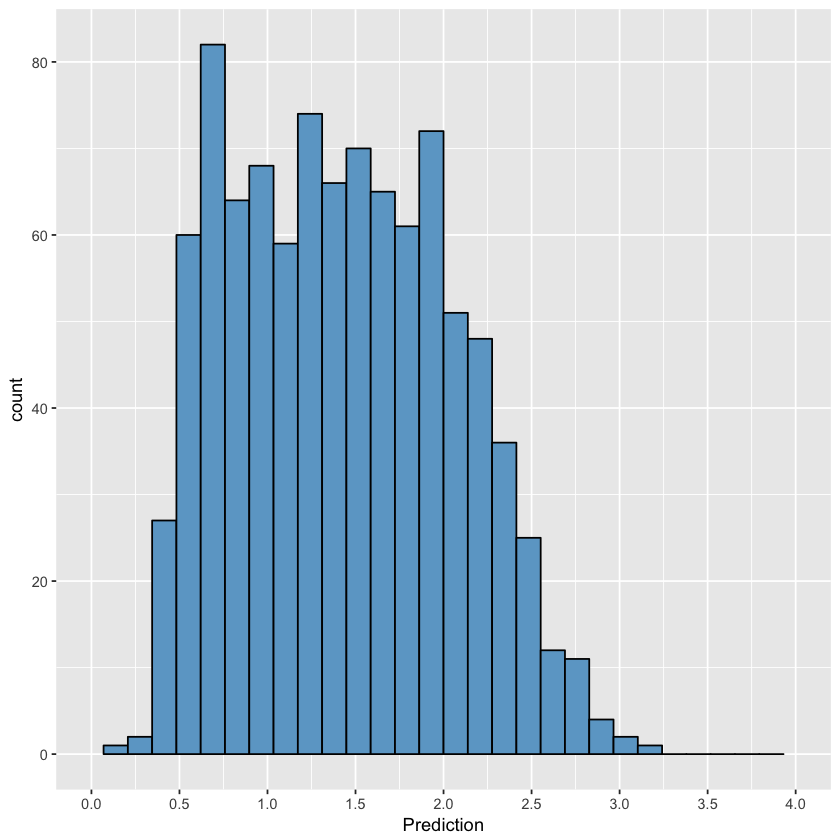

In [30]:
ggplot(data=model2_fulldata,aes(Prediction)) + geom_histogram(fill="skyblue3",col="black") +
scale_x_continuous(limits = c(0,4),breaks=seq(0,4,.5))

One thing to notice is that predicted values have less spread than the actual values. Models assume some regression to the mean and don't tend to predict extreme values.